## METHODOLOGY

> * The labeled data set is used to train a `VGG16` model by finetuning. The last 3 dense layesrs were stripped and replaced with a new layer or layers and the training was done only on the added layer or layers. For this, `5,000` `STL-10` images were used to train and cross-validate on 5 folds.   


> * Once trained, the model is used to predict the classes of the unlabelled dataset. Then the softmax outputs of the unlabeled images were calculated via forward pass. If the model outputted a softmax probability that exceeded a threshold value (~0.9, a hyperparameter) on any class, then that image was labeled to that class.  


> * Once labelled, the images from the previously unlabelled data set were added to the training set. The network was trained **all at once** on the expanded data set.  The test accuracy was calculated on the `8,000 STL-10` images.



## NOTES
> * Cross validation data set was split off from the training dataset in k=5 folds.  The K-fold Cross-validaton accuracy differed from the Test Accuracy substantially (98.5 to 94%, respectively). This raised suspicions whether the test and training sets were pulled form the same distribution. I was compelled to mix all the labeled data set (13,000 images), shuffle and select 5,000 for Training and 8,000 for Test datasets. 


> * After `Unlabeled_X.bin` was read into array and resized to `(224,224,3)`. `X_unlabeled_features`, the bottleneck features were computed via forward pass on `model_bottom`. Then `Unlabeled_X.bin` was deleted to create space to write `X_unlabeled_features` array (9.5 GB) to the disk.  

## RESULTS

#### Supervised Results:
```
5-Fold Training + Cross-validation on 5,000 STL-10 images
Test on 8,000 STL-10 images


                                                                1000 relu Layer    
                                          1000 relu Layer       1000 relu Layer    
                     1000 Softmax Layer   1000 Softmax Layer    1000 Softmax Layer
----------------------------------------------------------------------------------
Avg Test Accuracy :  96.66%               94.36%                94.39%

```
#### Unsupervised Results:
```
Avg Test Accuracy
threshold = 0.99 :   95.24 %              N/A                   N/A 
threshold = 0.95 :   95.47 %              95.23 %               N/A 
threshold = 0.90 :   95.49 %              N/A                   N/A 
threshold = 0.80 :   95.49 %              N/A                   N/A

```

> * With the expansion of the original training dataset into the unlabeled dataset, the Avg Test Accuracy has improved by approximately **1 %** for the value **threshold = 0.95**.






## ALTERNATIVE METHODOLOGY & FUTURE WORK

> * An alternative method, would be to set the threshold to a high level at first (like 0.99). Then label the unlabelled set to add to and expand the training dataset. Once the model is trainined on a larger dataset, the model will be more confident and robust. Now, the unlabelled images, with softmax probabilities previously predicted to be less than 0.99, will output different softmax probabilities once trained on the updated model. the threshold, a hyperparameter, can be held constant or be lowered slowly to absorb more images from the unlabelled dataset into the expanded traning set.



---

---

#### SUPERVISED PART:
> 1. Read in training and test `STL-10` datasets.   
> 2. Resize the original (96,96,3) images to (224,224,3)   
> 3. Obtain Bottleneck Features for VGG16...
> 4. Load VGG16 model weights pre-trained on Imagenet. Call it `model_bottom`.
> 5. Strip last 3 Dense Layers.
> 6. Do a forward pass with `X_train` and `X_test` on `model_bottom`. Save outputs as 
> 7. Construct a Neural Network that accepts VGG16 bottleneck features as input `(7,7,512)`. Call this `model_top`.
> 8. Perform k-fold with k=5 cross validation on `model_top`.
> 9. Print average Test Accuracy.

#### UNSUPERVISED PART:
> 10. Load unlabeled `STL-10` data into `X_unlabeled_raw`.
> 11. Resize original `(96,96,3)` images to `(224,224,3)`––call them `X_unlabeled_224`.
> 12. Compute `X_unlabeled_features` via forward pass on `model_bottom`.
> 13. Compute `y_unlabeled_predict` via forward pass of `X_unlabeled_features` on `model_top`.
> 14. Save `X_unlabeled_features` and `y_unlabeled_predict` to corresponding `.npy` files.
> 15. If max probability of `y_unlabeled_predict` exceeds a `threshold` level on any class, append that example to an additional training data `X_train_add` with according classes in `y_train_add`.
> 16. Instantiate a Neural Network with same architecture.
> 17. Train on the expanded dataset.

In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4236006328499133139
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 342622208
locality {
  bus_id: 1
}
incarnation: 9395491599803596506
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
from stl10_input import *
import os, sys, tarfile, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator

params =
{'legend.fontsize': 'x-large',
          'font.size'      : 10,
          'figure.figsize' : (17, 3),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)

DATA_PATH = './data/train_X.bin'
LABEL_PATH = './data/train_y.bin'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

# Supervised Part

### Read in training and test STL-10 datasets

In [12]:
with open('data/train_X.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    raw = np.reshape(raw, (-1, 3, 96, 96))
    raw = np.transpose(raw, (0,3,2,1))
    X_train_raw = raw
    
with open('data/train_y.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    y_train = raw - 1 # class labels are originally in 1-10 format. Convert them to 0-9 format

with open('data/test_X.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    raw = np.reshape(raw, (-1, 3, 96, 96))
    raw = np.transpose(raw, (0,3,2,1))
    X_test_raw = raw

with open('data/test_y.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    y_test = raw - 1 
    
#---------------------------------------------------------
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes = 1000)
y_test  = to_categorical(y_test , num_classes = 1000)

cnames, fidx = get_cnames_fidx(y_train, n_split=5)
print('All labeled data loaded.')

Class names retrieved in cnames
K-Fold indices generated, n_split = 5
Fold width = 1000
Number of data points for each class = 200
All labeled data loaded.


### Resize the original `(96,96,3)` images to `(224,224,3)` 


In [13]:
# takes ~20 sec to run.
start = time.time()
from PIL import Image

def resize_tensorimages(X_raw, interp_method=Image.BICUBIC):
    # VGG16 accepts input images of size (224, 224, 3)
    # Therefore, convert X_train_raw and X_test_raw to PIL.Image format, 
    # then resize the images from (96, 96, 3) to (224, 224, 3) 
    
    X_224 = np.zeros((X_raw.shape[0], 224, 224, 3))
    for i, _ in enumerate(X_raw):
        im = Image.fromarray(np.uint8(X_raw[i]))
        img = im.resize((224, 224), interp_method)
        X_224[i] = img
    
    return X_224

X_train = resize_tensorimages(X_train_raw)
X_test  = resize_tensorimages(X_test_raw)
    
del X_train_raw, X_test_raw
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print_runtime(start)

(5000, 224, 224, 3) (5000, 1000)
(8000, 224, 224, 3) (8000, 1000)
Runtime: 0 min 21 sec


---

# Obtain Bottleneck Features for VGG16
### 1.  Load VGG16 model weights pre-trained on Imagenet. Call it `model_bottom`.     


### 2.  Strip last 3 Dense Layers.   

In [14]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#---------------------------------------------------------

model_bottom = VGG16(include_top=False)

### 3. Do a forward pass with `X_train` and `X_test` on `model_bottom`.   Save outputs as `X_train_features` and `X_test_features`.

In [15]:
start = time.time()
#---------------------------------------------------------

# batch_size = 128

# X_train = preprocess_input(X_train) 
# X_test = preprocess_input(X_test) 
# d = model.predict(X_train[0:2])

# X_train_features = np.zeros((X_train.shape[0],*d.shape[1:]))

# for i in range(len(X_train)//batch_size):
#     idx = range(i*batch_size, (i+1)*batch_size)
#     print('Training set: %5.2f%%' % ((i+1)/(len(X_train)//batch_size)*100), end='\r')
#     X_train_features[idx] = model.predict(X_train[idx])    
# X_train_features[(i+1)*batch_size:] = model.predict(X_train[(i+1)*batch_size:])

# #---------------------------------------------------------
# print() 
# # Save `X_train_features` to `.npy` file, so you don't have to run this again.
# with open('data/X_train_features.npy', 'wb+') as f:
#     np.save(f, X_train_features)


### Load `X_train_features` from `.npy` file. 
with open('data/X_train_features.npy','rb') as f:
    X_train_features = np.load(f)     
#---------------------------------------------------------

### Compute `X_test_features` on pretrained `VGG16` model.
# X_test_features  = np.zeros((X_test.shape[0], *d.shape[1:]))
# for i in range(len(X_test)//batch_size):
#     idx = range(i*batch_size, (i+1)*batch_size)
#     print('Test set: %5.2f%%' % ((i+1)/(len(X_train)//batch_size)*100), end='\r')
#     X_test_features[idx] = model.predict(X_test[idx])
# X_test_features[(i+1)*batch_size:] = model.predict(X_test[(i+1)*batch_size:])

# print()
# # Save `X_test_features` to `.npy` file, so you don't have to run this again.
# with open('data/X_test_features.npy', 'wb+') as f:
#     np.save(f, X_test_features)


### Load `X_test_features` from `.npy` file.
with open('data/X_test_features.npy','rb') as f:
    X_test_features = np.load(f)
    
#---------------------------------------------------------
print_runtime(start)

Runtime: 0 min 12 sec


> * #### Training set and the cv set are drawn from the same dataset. Since there's a consistent and substantial difference between the test and validation accuracies (approximately 94% to 98.5%), I'm getting highly skeptical that test and the training datasets might be coming from different distributions. 

> * #### Try mixing original training and test sets and re-splitting the data into 5000 for the training and 8000 for the test set.

In [16]:
idx = list(range(13000))
np.random.shuffle(idx)
X_all = np.concatenate([X_train_features, X_test_features])
y_all = np.concatenate([y_train, y_test])

X_train_features = X_all[idx[:5000]]
y_train = y_all[idx[:5000]]
X_test_features = X_all[idx[5000:]]
y_test = y_all[idx[5000:]]

del X_all, y_all

### 5. Construct a Neural Network that accepts VGG16 bottleneck features as input. Call this `model_top`.

### 6. Perform k-fold with `k=5` cross validation on `model_top`.

### 7.  Print average Test Accuracy.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_78  (None, 512)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 1000)              513000    
Total params: 513,000
Trainable params: 513,000
Non-trainable params: 0
_________________________________________________________________
Initiate Training....
Epoch 00000: val_loss improved from inf to 0.89783, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.89783 to 0.42468, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.42468 to 0.32522, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss improved from 0.32522 to 0.28629, saving model to saved_models/model.best.hdf5
Epoch 00004: val_loss improved from 0.28629 to 0.27269, saving model to saved_models/model.best.hdf5
Epoch 000

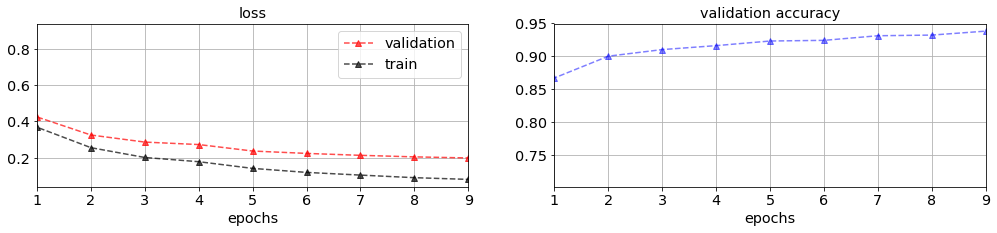

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.72674, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.72674 to 0.38868, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.38868 to 0.30382, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss improved from 0.30382 to 0.26781, saving model to saved_models/model.best.hdf5
Epoch 00004: val_loss improved from 0.26781 to 0.24180, saving model to saved_models/model.best.hdf5
Epoch 00005: val_loss improved from 0.24180 to 0.22866, saving model to saved_models/model.best.hdf5
Epoch 00006: val_loss improved from 0.22866 to 0.22026, saving model to saved_models/model.best.hdf5
Epoch 00007: val_loss improved from 0.22026 to 0.21123, saving model to saved_models/model.best.hdf5
Epoch 00008: val_loss improved from 0.21123 to 0.20639, saving model to saved_models/model.best.hdf5
Epoch 00009: val_loss improved from 0.20639 to 0.20476, saving model to s

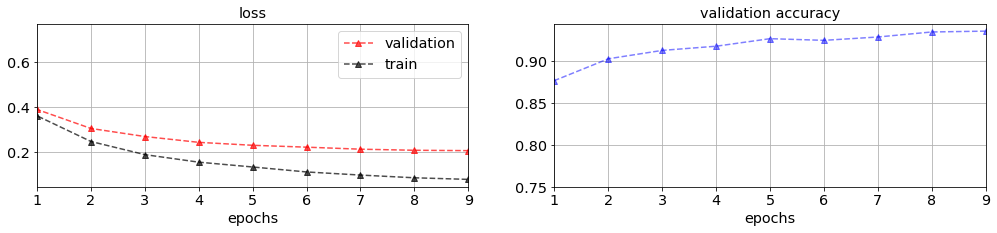

Initiate Training....
Epoch 00000: val_loss improved from inf to 1.02223, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 1.02223 to 0.55168, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.55168 to 0.41767, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss improved from 0.41767 to 0.37536, saving model to saved_models/model.best.hdf5
Epoch 00004: val_loss improved from 0.37536 to 0.33049, saving model to saved_models/model.best.hdf5
Epoch 00005: val_loss improved from 0.33049 to 0.30711, saving model to saved_models/model.best.hdf5
Epoch 00006: val_loss improved from 0.30711 to 0.27697, saving model to saved_models/model.best.hdf5
Epoch 00007: val_loss improved from 0.27697 to 0.25796, saving model to saved_models/model.best.hdf5
Epoch 00008: val_loss improved from 0.25796 to 0.24356, saving model to saved_models/model.best.hdf5
Epoch 00009: val_loss did not improve
Runtime: 0 min 19 sec
7808/8000 [==

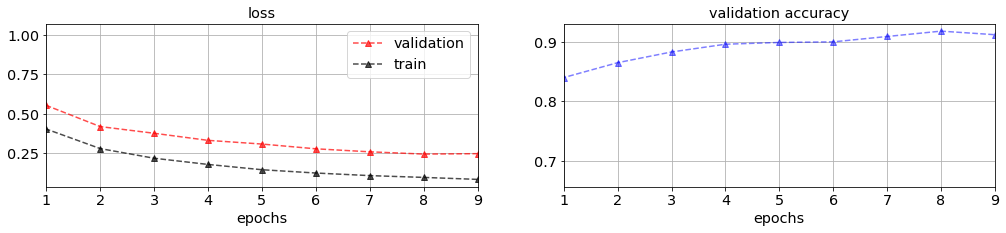

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.95266, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.95266 to 0.50638, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.50638 to 0.39532, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss improved from 0.39532 to 0.34905, saving model to saved_models/model.best.hdf5
Epoch 00004: val_loss improved from 0.34905 to 0.32725, saving model to saved_models/model.best.hdf5
Epoch 00005: val_loss improved from 0.32725 to 0.30976, saving model to saved_models/model.best.hdf5
Epoch 00006: val_loss improved from 0.30976 to 0.29228, saving model to saved_models/model.best.hdf5
Epoch 00007: val_loss improved from 0.29228 to 0.28518, saving model to saved_models/model.best.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 0.28518 to 0.27341, saving model to saved_models/model.best.hdf5
Runtime: 0 min 19 sec
7808/8000 [==

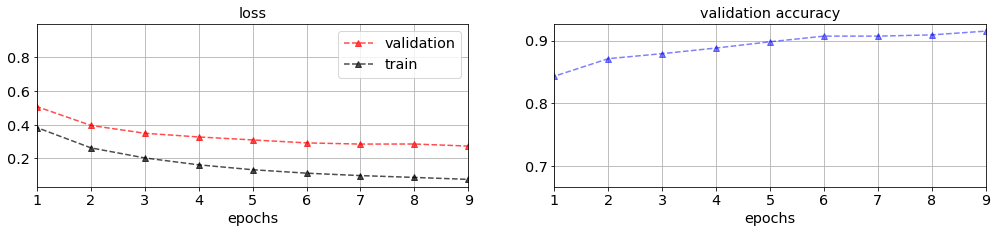

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.89647, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.89647 to 0.46276, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.46276 to 0.36985, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss improved from 0.36985 to 0.32468, saving model to saved_models/model.best.hdf5
Epoch 00004: val_loss improved from 0.32468 to 0.29215, saving model to saved_models/model.best.hdf5
Epoch 00005: val_loss improved from 0.29215 to 0.26802, saving model to saved_models/model.best.hdf5
Epoch 00006: val_loss improved from 0.26802 to 0.25912, saving model to saved_models/model.best.hdf5
Epoch 00007: val_loss improved from 0.25912 to 0.24212, saving model to saved_models/model.best.hdf5
Epoch 00008: val_loss improved from 0.24212 to 0.24055, saving model to saved_models/model.best.hdf5
Epoch 00009: val_loss improved from 0.24055 to 0.22830, saving model to s

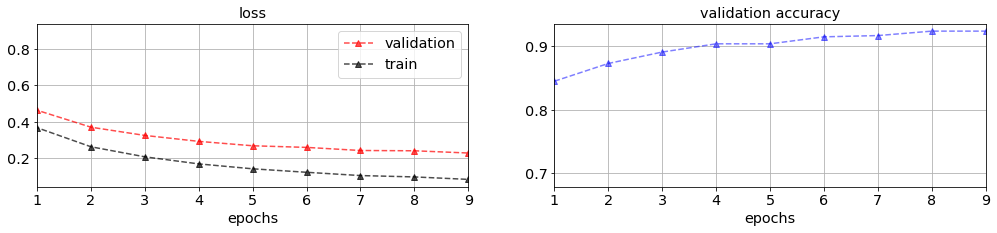



------------------------------
------------------------------
In 5 Folds
K-Fold Average Test Accuracy = 92.57 %  <==
Runtime: 1 min 46 sec


In [67]:
start = time.time()
acc = []

### Do a 5 k-fold
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5, shuffle=True)
# for fidx_train, fidx_cv in kf.split(y_train):
for k, _ in enumerate(fidx):
    fidx_cv = fidx[k]
    fidx_train = np.concatenate([fidx[0:k],fidx[k+1:]]).flatten()
    
    X_cv_features_1k = X_train_features[fidx_cv]
    y_cv_1k = y_train[fidx_cv]
    
    X_train_features_9k = X_train_features[fidx_train]
    y_train_9k = y_train[fidx_train]
    
    
    ### 5. Construct a Neural Network that accepts VGG16 bottleneck features as input. Call this `model_top`.
    model_top = construct_model()
    if k == 0: model_top.summary()
    ### 6. Train `model_top` on  `X_train_features` with validation on `(X_cv_features, y_cv)`.
    model_top, callback_inst = train_model(model_top, 
                                           X_train_features_9k, y_train_9k,
                                           X_cv_features_1k, y_cv_1k, 
                                           epochs=10,
                                           batch_size=128,
                                           wanna_plot=False)
    ### 7.  Compute test accuracy.
    model_top.load_weights('saved_models/model.best.hdf5')

    _loss, _acc = model_top.evaluate(X_test_features, y_test, 
                                    batch_size=128);
    acc.append(_acc)
    print('\nAt k = %i, \nTest Accuracy = %.2f %%' % (k, _acc*100))

    ### Plot loss function and accuracy
    callback_inst.plotter()

print(('\n' + ('\n'+'-'*30)*2 +'\nIn %i Folds'+ '\nK-Fold Average Test Accuracy = %.2f %%  <==') % 
      (len(fidx), np.mean(acc)*100))
print_runtime(start)


---

# UNSUPERVISED PART
### Load unlabeled STL-10 data into `X_unlabeled_raw`.

In [241]:
## 2.8 GB !!! 
# The (224, 224, 3) tensor will not fit in memory.
# Build a generator
# with open('data/unlabeled_X.bin') as f:
#     raw = np.fromfile(f, dtype=np.uint8, count=-1)
#     raw = np.reshape(raw, (-1, 3, 96, 96))
#     raw = np.transpose(raw, (0,3,2,1))
#     X_unlabeled_raw = raw

# print(X_unlabeled_raw.shape)  
# print('X_unlabeled_raw.nbytes = %.2f MB' % (X_unlabeled_raw.nbytes/1e6)  )

### 8. Resize original `(96,96,3)` images to `(224,224,3)`––call them `X_unlabeled_224`.
### 9.  Compute `X_unlabeled_features ` via forward pass on `model_bottom`.
### 10.  Compute `y_unlabeled_predict` via forward pass of `X_unlabeled_features` on `model_top`.  
### 11. Save `X_unlabeled_features` and `y_unlabeled_predict` to corresponding `.npy` files.


In [242]:
# # NPY FILE MAKER

# start = time.time()

# # .....................................................................

# batch_size = 128
# sno = -1
# n_batches = len(X_unlabeled_raw)//batch_size

# X_unlabeled_raw = X_unlabeled_raw.astype('float32')
# X_unlabeled_features_repo = np.array([])

# for i in range(0, n_batches):
#     idx = range(i*batch_size, min((i+1)*batch_size, len(X_unlabeled_raw)))

#     # Resize raw image tensors.
#     X_unlabeled_224 = resize_tensorimages(X_unlabeled_raw[idx])
    
#     # Forward pass X_unlabeled_224 on model_bottom.
#     # (This is the time-consuming step.)
#     # X_unlabeled_features.shape = (128, 7, 7, 512)
#     X_unlabeled_features = model_bottom.predict(X_unlabeled_224, batch_size=batch_size) 
    
#     # Retrieve softmax probabilities on all classes.
#     # y_unlabeled_softmax.shape = (128, 1000)
#     y_unlabeled_softmax = model_top.predict(X_unlabeled_features) 
    
#     diff = time.time()-start
#     print('i = %d, n_batches = %d, Time: %d min %d sec  ' % (i, n_batches, diff//60, diff%60), end='\r')
    
#     if len(X_unlabeled_features_repo.shape) == 1:
#         X_unlabeled_features_repo = X_unlabeled_features
#         y_unlabeled_softmax_repo  = y_unlabeled_softmax
#     else:
#         X_unlabeled_features_repo = np.concatenate([X_unlabeled_features_repo, X_unlabeled_features])
#         y_unlabeled_softmax_repo  = np.concatenate([y_unlabeled_softmax_repo , y_unlabeled_softmax])
    
#     if X_unlabeled_features_repo.nbytes > 250*1e6:
#         sno = sno + 1
#         print()
#         npy_saver(X_unlabeled_features_repo, 'X_unlabeled_features', sno)
#         npy_saver(y_unlabeled_softmax_repo , 'y_unlabeled_softmax' , sno)
#         print('---------------------------------------------------------')
#         X_unlabeled_features_repo = np.array([])

# if len(X_unlabeled_features_repo) > 1:
#     sno = sno + 1
#     print()
#     npy_saver(X_unlabeled_features_repo, 'X_unlabeled_features', sno)
#     npy_saver(y_unlabeled_softmax_repo , 'y_unlabeled_softmax' , sno)

# del X_unlabeled_features_repo, y_unlabeled_softmax_repo, X_unlabeled_224
# print_runtime(start)
# print('\nDone!!')

### 12.  If max probability of `y_unlabeled_predict` exceeds `threshold = 0.9` on any class, append that example to an additional training data `X_train_add` with the class `y_train_add`.
##### Each `X_unlabeled_features_**.npy` is of length `2560` and size `257 MB`.

In [71]:
start = time.time()

threshold = .95
outX = []
outy = []

X_train_add_features = np.array([]) 
import glob
npys = glob.glob('data/*_softmax_*npy')
npys.sort(reverse=True)
highest_sno = int(npys[0].split('.npy')[0].split('_')[-1])

print('threshold = %.2f' % (threshold))
for sno in range(0, highest_sno):
    with open('data/%s_%02d.npy' % ('X_unlabeled_features', sno), 'rb') as fX,\
        open('data/%s_%02d.npy' % ('y_unlabeled_softmax', sno), 'rb') as fy:
        
        print('Reading in:', fX.name, ', ', fy.name , end='\r')
        X_unlabeled_features = np.load(fX) # shape (2560, 7, 7, 512)
        y_unlabeled_softmax  = np.load(fy) # (2560, 1000)

    # Find index of predicted class.
    # topclass_idx.shape = (2560,)
    topclass_idx = np.argmax(y_unlabeled_softmax, axis=1) 
    
    # prob: probability associated with topclass. shape = (2560,)
    prob = y_unlabeled_softmax[ range(y_unlabeled_softmax.shape[0]) , topclass_idx ]
    predict_idx = np.where(prob > threshold)[0]
    
    outX.append(X_unlabeled_features[predict_idx] )
    onehot = np.zeros((len(predict_idx) , 1000))
    onehot[range(len(predict_idx)), topclass_idx[predict_idx] ] = 1
    outy.append(onehot)
    
# ................................................................    
# with open('data/X_train_add_features.npy', 'wb+') as fX, \
#     open('data/y_train_add.npy', 'wb+') as fy:
#     np.save(fX, X_train_add_features)
#     np.save(fy, y_train_add)


X_train_add_features = np.concatenate(outX)
y_train_add = np.concatenate(outy)

print('\n', X_train_add_features.shape, y_train_add.shape)
print_runtime(start)

threshold = 0.95
Reading in: data/X_unlabeled_features_38.npy ,  data/y_unlabeled_softmax_38.npy
 (57089, 7, 7, 512) (57089, 1000)
Runtime: 0 min 9 sec


In [72]:
X_train_add_features.nbytes/1e9

5.728995328

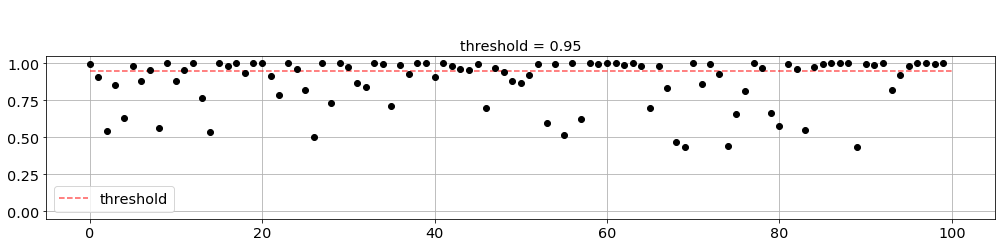

In [83]:
plt.plot([0,100],[threshold]*2, 'r--', alpha = .65);
plt.plot(prob[:100],'ko');
plt.gca().set_ylim([-0.05,1.05]);
plt.gca().legend(['threshold']);
plt.title('\n\nthreshold = %.2f' % (threshold));

### 13. Instantiate a Neural Network with same architecture.
### 14. Train on expanded dataset.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_85  (None, 512)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 1000)              513000    
_________________________________________________________________
dense_138 (Dense)            (None, 1000)              1001000   
Total params: 1,514,000
Trainable params: 1,514,000
Non-trainable params: 0
_________________________________________________________________
Initiate Training....
Epoch 00000: val_loss improved from inf to 0.24125, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.24125 to 0.17775, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss di

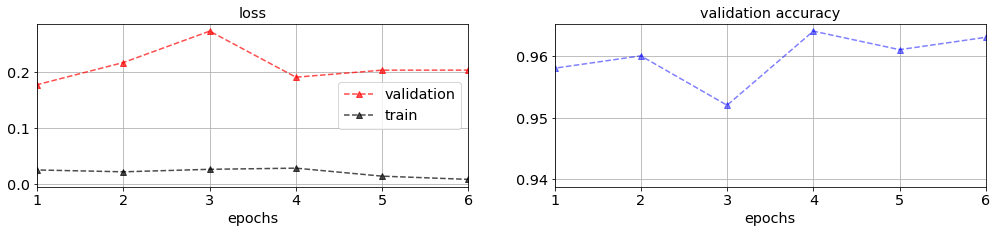

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.19403, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Runtime: 2 min 42 sec
7808/8000 [============================>.] - ETA: 0s
At k = 1, 
Test Accuracy = 95.38 %


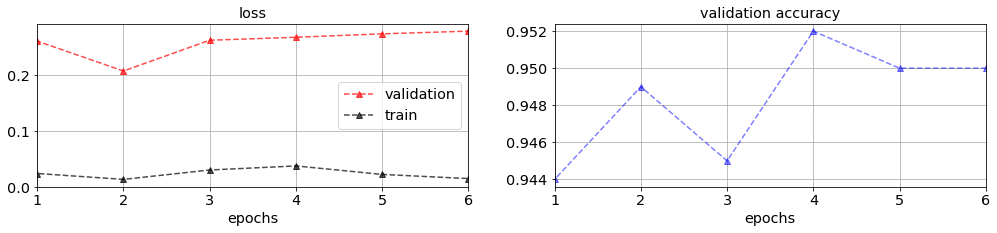

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.19976, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.19976 to 0.19379, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.19379 to 0.17160, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Runtime: 2 min 41 sec
7808/8000 [============================>.] - ETA: 0s
At k = 2, 
Test Accuracy = 95.54 %


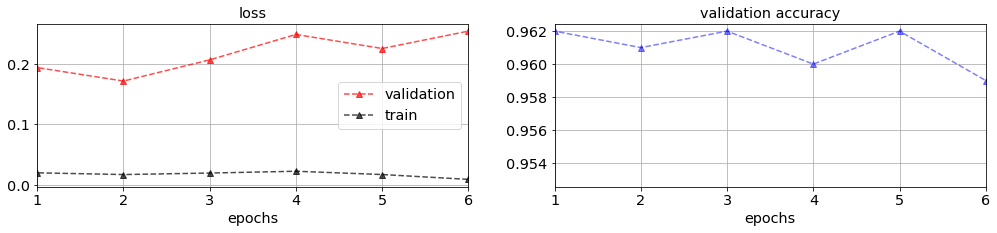

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.28591, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Runtime: 2 min 41 sec
7936/8000 [============================>.] - ETA: 0s
At k = 3, 
Test Accuracy = 95.08 %


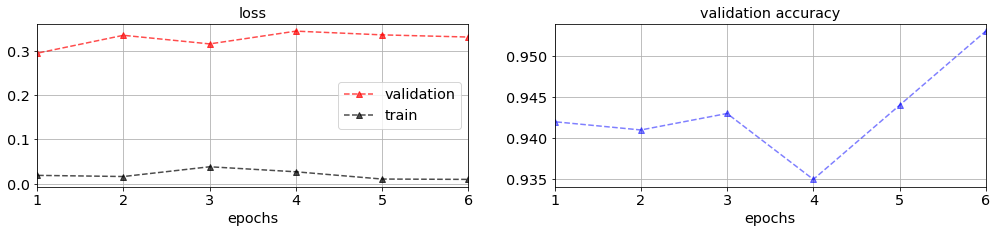

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.16284, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Runtime: 2 min 39 sec
7680/8000 [===========================>..] - ETA: 0s
At k = 4, 
Test Accuracy = 94.91 %


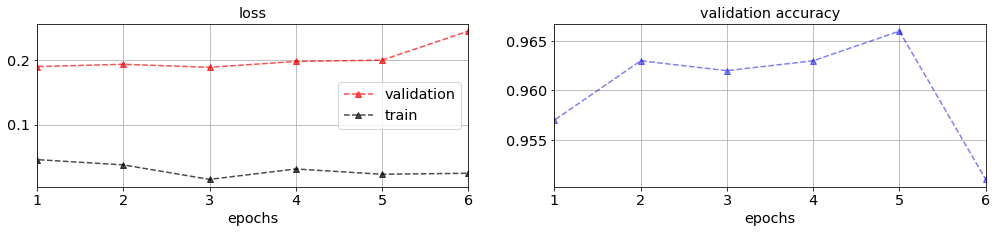

threshold = 0.95


------------------------------
------------------------------
In 5 Folds
K-Fold Average Test Accuracy = 95.23 %  <==
Runtime: 14 min 23 sec


In [84]:
start = time.time()
acc = []

### Do a 5 k-fold
for k, _ in enumerate(fidx):
    fidx_cv = fidx[k]
    fidx_train = np.concatenate([fidx[0:k],fidx[k+1:]]).flatten()
    
    X_cv_features_1k = X_train_features[fidx_cv]
    y_cv_1k = y_train[fidx_cv]
    
    X_train_features_9k = np.concatenate([X_train_features[fidx_train], X_train_add_features])
    y_train_9k = np.concatenate([y_train[fidx_train], y_train_add])
    
    
    ### 5. Construct a Neural Network that accepts VGG16 bottleneck features as input. Call this `model_top`.
    model_top = construct_model()
    if k == 0: model_top.summary()
    ### 6. Train `model_top` on  `X_train_features` with validation on `(X_cv_features, y_cv)`.
    model_top, callback_inst = train_model(model_top, 
                                           X_train_features_9k, y_train_9k,
                                           X_cv_features_1k, y_cv_1k, 
                                           epochs=7,
                                           batch_size=128,
                                           wanna_plot=False)
    ### 7.  Compute test accuracy.
    model_top.load_weights('saved_models/model.best.hdf5')

    _loss, _acc = model_top.evaluate(X_test_features, y_test, 
                                    batch_size=128);
    acc.append(_acc)
    print('\nAt k = %i, \nTest Accuracy = %.2f %%' % (k, _acc*100))

    ### Plot loss function and accuracy
    callback_inst.plotter()

print('threshold = %.2f' % (threshold))
print(('\n' + ('\n'+'-'*30)*2 +'\nIn %i Folds'+ '\nK-Fold Average Test Accuracy = %.2f %%  <==') % 
      (len(fidx), np.mean(acc)*100))
print_runtime(start)

In [66]:
# !git status
# !git add .
# !git commit -m "1 layer w/ threshold=.99,.95,0.90,.80"
# !git push -u origin master